In [1]:
import numpy as np
from mrftools import *

N = 25
lmb = 10
r_s = -5
r_h = -2


# uncontrolled dynamics
def phi_q(x1, x2):
    x1_x, x1_y = x1
    x2_x, x2_y = x2
    ind = ((x2_x == x1_x) and (x2_y == x1_y)) or \
            (x2_x == x1_x - 1) and (x2_y == x1_y) and (x1_x > 0) or \
            (x2_x == x1_x) and (x2_y == x1_y - 1) and (x1_y > 0) or \
            (x2_x == x1_x + 1) and (x2_y == x1_y) and (x1_x < np.sqrt(N)) or \
            (x2_x == x1_x) and (x2_y == x1_y + 1) and (x1_y < np.sqrt(N))
    return 1 if ind else 0

# from index in {0,...,N-1} to position (x,y) in {1,...,sqrt(N)}^2
def get_pos(index, N):
    index = index + 1 
    r = np.remainder(index, np.sqrt(N))
    if r == 0:
        x = np.sqrt(N)
        y = index // np.sqrt(N)
    else:
        x = r
        y = index // np.sqrt(N) + 1
    return x, y

# build uncontrolled dynamics matrix factor
phi_q_factor = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        phi_q_factor[i, j] = phi_q(get_pos(i, N), get_pos(j, N))

mn = MarkovNet()

factor = np.array(N*[-float('inf')]) # factor = np.zeros(N)
factor[1] = 1
mn.set_unary_factor('x11', factor)

factor = np.array(N*[-float('inf')]) # factor = np.zeros(N)
factor[14] = 1
mn.set_unary_factor('x12', factor)

mn.set_unary_factor('x21', np.ones(N))
mn.set_unary_factor('x31', np.ones(N))
#mn.set_unary_factor('x41', np.ones(N))
mn.set_unary_factor('x22', np.ones(N))
mn.set_unary_factor('x32', np.ones(N))
#mn.set_unary_factor('x42', np.ones(N))

r_hare = np.exp(-(r_h/lmb))
factor_h = np.ones(N)
factor_h[0] = r_hare
factor_h[4] = r_hare
factor_h[20] = r_hare
factor_h[24] = r_hare
mn.set_unary_factor('x41', factor_h)
mn.set_unary_factor('x42', factor_h)


mn.set_edge_factor(('x11', 'x21'), phi_q_factor)
mn.set_edge_factor(('x21', 'x31'), phi_q_factor)
mn.set_edge_factor(('x31', 'x41'), phi_q_factor)
mn.set_edge_factor(('x12', 'x22'), phi_q_factor)
mn.set_edge_factor(('x22', 'x32'), phi_q_factor)
mn.set_edge_factor(('x32', 'x42'), phi_q_factor)


r_stag = np.exp(-(r_s/lmb))
factor_s = np.ones((N, N))
factor_s[(12,12)] = r_stag
mn.set_edge_factor(('x41', 'x42'), factor_s)


bp = BeliefPropagator(mn)

In [2]:
bp.infer(display='full')
bp.load_beliefs()

Iteration 0, change in messages 1111.462031. Calibration disagreement: 1.064498, energy functional: 49.858392, dual obj: 49.939009
Iteration 1, change in messages 52.750608. Calibration disagreement: 0.127637, energy functional: 49.889437, dual obj: 49.886690
Iteration 2, change in messages 13.521874. Calibration disagreement: 0.000000, energy functional: 49.880018, dual obj: 49.880018
Iteration 3, change in messages 1.556513. Calibration disagreement: 0.000000, energy functional: 49.880018, dual obj: 49.880018
Iteration 4, change in messages 0.000000. Calibration disagreement: 0.000000, energy functional: 49.880018, dual obj: 49.880018
Belief propagation finished in 5 iterations.


In [3]:
mn.unary_potentials

{'x11': array([-inf,   1., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf]),
 'x12': array([-inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf,   1., -inf, -inf, -inf, -inf, -inf, -inf, -inf,
        -inf, -inf, -inf]),
 'x21': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'x31': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'x22': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'x32': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]),
 'x41': array([3.75965765, 1.        , 1.        , 1.        , 3.75965765,
        1.        , 1.        , 1.        , 1.        , 1. 

In [4]:
mn.edge_potentials

{('x11',
  'x21'): array([[1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0

In [21]:
np.exp(bp.var_beliefs['x11'])

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
np.exp(bp.pair_beliefs[('x11','x21')])

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.07962478, 0.08427162, 0.08454715, 0.0310018 , 0.02929232,
        0.0310018 , 0.08952715, 0.03297834, 0.0329352 , 0.0310018 ,
        0.03110316, 0.03297834, 0.03311136, 0.03297834, 0.03110316,
        0.0310018 , 0.0329352 , 0.03297834, 0.0329352 , 0.0310018 ,
        0.02929232, 0.0310018 , 0.03110316, 0.0310018 , 0.02929232],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [13]:
with np.errstate(divide='ignore', invalid='ignore'):
    trans_mat = np.transpose(np.transpose(np.exp(bp.pair_beliefs[('x11','x21')])) / np.exp(bp.var_beliefs['x11']))
trans_mat

NameError: name 'bp' is not defined

In [1]:
import numpy as np
from staghunt import StagHuntMRF

In [2]:
test = StagHuntMRF()
#test.new_game_sample(size=(5,5), num_agents=4)
test.lmb = 10
test.r_h = -3
test.r_s = -10
test.horizon = 5

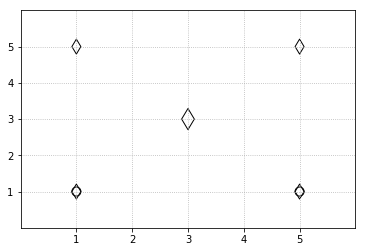

5
Belief propagation finished in 5 iterations.


KeyError: ('x51', 'x61')

In [7]:
test.display()
print(test.horizon)

if test.horizon > 1:
    test.build_model()
    test.infer(inference_type='slow',max_iter=3000)
    test.compute_probabilities()
    test.move_next()

In [1]:
import numpy as np
from staghunt import StagHuntMRF

In [2]:
test = StagHuntMRF()
test.lmb = 0.1
test.r_h = -2
test.r_s = -10
test.horizon = 4
test.build_model()
#test.infer(inference_type='slow',max_iter=30000)

In [3]:
# init messages
messages= dict()
for var in test.mrf.variables:
    for neighbor in test.mrf.get_neighbors(var):
        messages[(var, neighbor)] = np.zeros(test.mrf.num_states[neighbor])

In [4]:
def logsumexp(matrix, dim=None):
    """
    Compute log(sum(exp(matrix), dim)) in a numerically stable way.
    """
    max_val = matrix.max()
    return np.log(np.sum(np.exp(matrix - max_val), dim)) + max_val

# init var beliefs
var_beliefs = dict()
for var in test.mrf.variables:
    belief = test.mrf.unary_potentials[var]
    log_z = logsumexp(belief)
    belief = belief - log_z
    var_beliefs[var] = belief

# init pair beliefs
caca = 0
pair_beliefs = dict()
for var in test.mrf.variables:
    for neighbor in test.mrf.get_neighbors(var):
        belief = test.mrf.get_potential((var, neighbor))
        print(belief)
        foo = np.sum(belief)
        log_z = logsumexp(foo)
        belief = belief - log_z
        pair_beliefs[(var, neighbor)] = belief

[[ 0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [ 0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5.  0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5. -5.  0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5. -5. -5.  0.  0. -5. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [ 0. -5. -5. -5. -5.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5.  0. -5. -5. -5.  0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5. -5.  0. -5. -5. -5.  0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5. -5. -5.  0. -5. -5. -5.  0.  0.  0. -5. -5. -5.  0. -5. -5. -5. -5.
  -5. -5. -5. -5. -5. -5. -5.]
 [-5. -5. -5. -5.  0. -5. -5. -5.  0.  0. -5. -5. -5. -

In [ ]:
test = StagHuntMRF()
test.new_game_sample(size=(5,5), num_agents=2)
test.display()

In [16]:
FOO_CONST = [(1,2)]
BAR_CONST = [(1,2)]

class Test:
    def __init__(self, foo = FOO_CONST, bar = BAR_CONST.copy()):
        self.my_bar = bar
        self.my_foo = foo
        print(CONST, foo, bar)
    
    def change(self):
        self.my_bar[0] = (2,3)
        self.my_foo[0] = (2,3)

test = Test()
print(CONST, test.my_foo, test.my_bar)
test.change()
print(CONST, test.my_foo, test.my_bar)
test = Test()

[(1, 2)] [(1, 2)] [(1, 2)]
[(1, 2)] [(1, 2)] [(1, 2)]
[(1, 2)] [(2, 3)] [(2, 3)]
[(1, 2)] [(2, 3)] [(2, 3)]


In [7]:
import numpy as np
from staghunt import StagHuntMRF

In [8]:
test = StagHuntMRF()
test.lmb = 0.01
test.r_h = -2
test.r_s = -10
test.horizon = 4

In [172]:
test.build_ground_model()
test.infer()
test.compute_probabilities()
caca = np.exp(test.bp.pair_beliefs[('x11','x21')])
round_by_tol(caca, 10e-4)

Belief propagation finished in 2 iterations.


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.33310647, 0.22213146, 0.22213146, 0.        , 0.        ,
        0.        , 0.22215161, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [1]:
import numpy as np
from staghunt import StagHuntMRF

In [2]:
test = StagHuntMRF()
test.lmb = 10
test.r_h = -2
test.r_s = -10
test.horizon = 4

In [3]:
test.build_ground_model()
test.infer(inference_type='slow',max_iter=3000)
test.compute_probabilities()
test.move_next()

Belief propagation finished in 5 iterations.


In [3]:
from staghunt import *
import numpy as np

In [56]:
test = StagHuntMRF()
#test.new_game_sample(size=(5,5), num_agents=4)
test.lmb = 0.1
test.r_h = -5
test.r_s = -10
test.horizon = 5
test.build_model()

In [57]:
for i in range(test.horizon-1):
    test.infer()
    test.compute_probabilities()
    test.move_next()
    test.update_model()
    
for agent in [1,2]:
    caca=\
    [test.get_pos(np.argmax(test.mrf.unary_potentials['x' + str(i) + str(agent)])) for i in range(1,test.horizon+1)]
    print(caca)

Belief propagation finished in 13 iterations.
Belief propagation finished in 12 iterations.
Belief propagation finished in 10 iterations.
Belief propagation finished in 8 iterations.
[(2, 1), (2, 1), (1, 1), (1, 1), (1, 1)]
[(5, 3), (5, 2), (5, 1), (4, 1), (5, 1)]


In [43]:
prova = StagHuntMRF()
#test.new_game_sample(size=(5,5), num_agents=4)
prova.lmb = 0.2
prova.r_h = -2
prova.r_s = -10
prova.horizon = 10
prova.build_model()

In [45]:
test.infer()
prova.infer()

Belief propagation finished in 9 iterations.
Belief propagation finished in 17 iterations.


In [46]:
round_by_tol(np.exp(prova.bp.pair_beliefs[('x11', 'x21')]), 10e-5)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.12264066, 0.21746591, 0.2608447 , 0.        , 0.        ,
        0.        , 0.39904874, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

In [1]:
import numpy as np
from staghunt import *

In [5]:
lmb = 0.1
r_h = -5
r_s = -10
horizon = 4
size = (5,5)
num_agents = 2

slow = StagHuntMRF()
#slow.lmb, slow.r_h, slow.r_s, slow.horizon = lmb, r_h, r_s, horizon
#slow.new_game_sample(size=size, num_agents=num_agents)

matrix = StagHuntMRF()
matrix2 = StagHuntMRF()
#matrix.lmb, matrix.r_h, matrix.r_s, matrix.horizon, matrix.size = lmb, r_h, r_s, horizon, size
#matrix.set_game_config(slow.get_game_config())

#if len(slow.aPos)==2:
#    ground = StagHuntMRF()
#    ground.lmb, ground.r_h, ground.r_s, ground.horizon, ground.size = lmb, r_h, r_s, horizon, size
#    ground.set_game_config(slow.get_game_config())

slow.build_model()
matrix.build_model()
matrix2.build_model()
#if len(slow.aPos)==2:
#    ground.build_ground_model()

Belief propagation finished in 11 iterations.
Belief propagation finished in 10 iterations.
Belief propagation finished in 8 iterations.
[(2, 1), (2, 2), (3, 2), (3, 3)] stag
[(5, 3), (4, 3), (3, 3), (3, 3)] stag


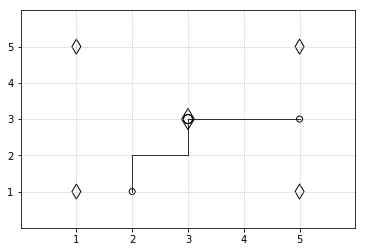

In [6]:
for i in range(slow.horizon-1):
    slow.infer(inference_type='slow')
    slow.compute_probabilities()
    slow.move_next()
    slow.update_model()
    
for agent in range(1, len(slow.aPos) + 1):
    trajectory = []
    for i in range(1, slow.horizon+1):
        trajectory.append(slow.get_pos(np.argmax(slow.mrf.unary_potentials['x' + str(i) + str(agent)])))
    if trajectory[-1] in slow.hPos:
        sth = 'hare'
    elif trajectory[-1] in slow.sPos:
        sth = 'stag'
    else:
        sth = 'nothing'
    print(trajectory, sth)
slow.display()

Belief propagation finished in 11 iterations.
Belief propagation finished in 10 iterations.
Belief propagation finished in 8 iterations.
[(2, 1), (2, 2), (3, 2), (3, 3)] stag
[(5, 3), (4, 3), (3, 3), (3, 3)] stag


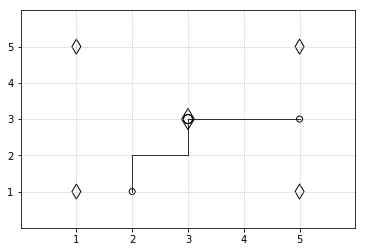

In [7]:
for i in range(matrix.horizon-1):
    matrix.infer(inference_type='matrix')
    matrix.compute_probabilities()
    matrix.move_next()
    matrix.update_model()
    
for agent in range(1, len(matrix.aPos) + 1):
    trajectory = []
    for i in range(1, matrix.horizon+1):
        trajectory.append(matrix.get_pos(np.argmax(matrix.mrf.unary_potentials['x' + str(i) + str(agent)])))
    if trajectory[-1] in matrix.hPos:
        sth = 'hare'
    elif trajectory[-1] in matrix.sPos:
        sth = 'stag'
    else:
        sth = 'nothing'
    print(trajectory, sth)
matrix.display()

Belief propagation finished in 46 iterations.
Belief propagation finished in 55 iterations.
Belief propagation finished in 25 iterations.
[(1, 2), (2, 2), (2, 2), (2, 1)] hare
[(3, 2), (3, 3), (3, 4), (3, 4)] stag
[(4, 1), (4, 2), (4, 3), (4, 2)] hare
[(5, 4), (4, 4), (4, 4), (3, 4)] stag
[(5, 5), (4, 5), (4, 4), (3, 4)] stag


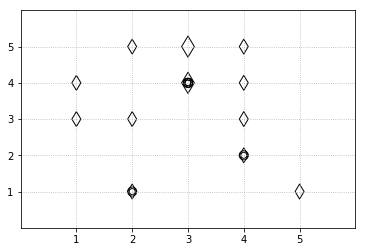

In [70]:
matrix2 = StagHuntMRF()
matrix2.new_game_sample(size=(5,5), num_agents=5)
matrix2.build_model()

trajectories = [matrix2.aPos.copy()]
for i in range(matrix2.horizon-1):
    matrix2.infer(inference_type='matrix')
    matrix2.compute_probabilities()
    matrix2.move_next()
    matrix2.time = 1
    matrix2.horizon -= 1
    matrix2.build_model()
    trajectories.append(matrix2.aPos.copy())
    
trajectories = list(map(list, zip(*trajectories)))
for trajectory in trajectories:
    if trajectory[-1] in matrix2.hPos:
        sth = 'hare'
    elif trajectory[-1] in matrix2.sPos:
        sth = 'stag'
    else:
        sth = 'nothing'
    print(trajectory, sth)
matrix2.display()

In [ ]:
for i in range(ground.horizon-1):
    ground.infer(inference_type='slow')
    ground.compute_probabilities()
    ground.move_next()
    ground.update_model()
    
for agent in range(1, len(ground.aPos) + 1):
    trajectory = []
    for i in range(1, ground.horizon+1):
        trajectory.append(ground.get_pos(np.argmax(ground.mrf.unary_potentials['x' + str(i) + str(agent)])))
    if trajectory[-1] in ground.hPos:
        sth = 'hare'
    elif trajectory[-1] in ground.sPos:
        sth = 'stag'
    else:
        sth = 'nothing'
    print(trajectory, sth)
ground.display()

In [16]:
matrix2.infer(inference_type='matrix')

Belief propagation finished in 11 iterations.


In [17]:
matrix2.compute_probabilities()

In [11]:
matrix2.move_next()
matrix2.update_model()

In [4]:
matrix2.infer(inference_type='matrix')
matrix2.compute_probabilities()
matrix2.move_next()
matrix2.update_model()

Belief propagation finished in 11 iterations.


In [5]:
matrix2.infer(inference_type='matrix')
matrix2.compute_probabilities()
matrix2.move_next()
matrix2.update_model()

Belief propagation finished in 11 iterations.


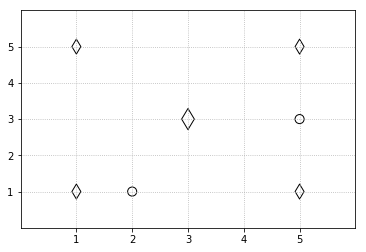

In [4]:
matrix2.display()

In [39]:
matrix = StagHuntMRF()
matrix.build_model()

In [20]:
matrix.infer(inference_type='slow')
matrix.compute_probabilities()
matrix.move_next()
matrix.update_model()

Belief propagation finished in 11 iterations.


In [21]:
matrix2 = StagHuntMRF()
matrix2.build_model()

In [22]:
matrix2.infer(inference_type='matrix')
matrix2.compute_probabilities()
matrix2.move_next()
matrix2.update_model()

Belief propagation finished in 11 iterations.


In [38]:
np.all(matrix2.mrf.edge_pot_tensor == matrix.mrf.edge_pot_tensor)

True

In [74]:
advance = StagHuntMRF()
advance.build_model()
advance.infer(inference_type='slow')
advance.compute_probabilities()
advance.move_next()
advance.time = 1
advance.horizon -= 1
advance.build_model()

advance.infer(inference_type='slow')

Belief propagation finished in 11 iterations.
Belief propagation finished in 9 iterations.


In [75]:
clamp = StagHuntMRF()
clamp.build_model()
clamp.infer(inference_type='slow')
clamp.compute_probabilities()
clamp.move_next()
clamp.update_model()
clamp.infer(inference_type='slow')

Belief propagation finished in 11 iterations.
Belief propagation finished in 10 iterations.


In [76]:
for key in matrix.bp.var_beliefs:
    print(key, np.allclose(clamp.bp.var_beliefs[key], advance.bp.var_beliefs[key]))

d21 True
u21 True
x21 False
x12 False
x11 False
x31 False
x32 False
d11 True
x22 False
z21 True


In [78]:
advance.bp.var_beliefs['x11']

array([-100.71018073, -100.36681773, -100.29960288, -100.36681773,
       -100.71018073, -100.36681773,    0.        ,  -99.97679005,
       -100.        , -100.36681773, -100.29960288,  -99.97679005,
        -99.91959431,  -99.97679005, -100.29960288, -100.36681773,
       -100.        ,  -99.97679005, -100.        , -100.36681773,
       -100.71018073, -100.36681773, -100.29960288, -100.36681773,
       -100.71018073])

In [79]:
clamp.bp.var_beliefs['x21']

array([-100.71018073, -100.36681773, -100.29960288, -198.75737982,
       -199.32388637, -198.75737982,    0.        , -198.18503058,
       -198.20824053, -198.75737982, -198.69016496, -198.18503058,
       -198.12783484, -198.18503058, -198.69016496, -198.75737982,
       -198.20824053, -198.18503058, -198.20824053, -198.75737982,
       -199.32388637, -198.75737982, -198.69016496, -198.75737982,
       -199.32388637])

In [80]:
uep = [[(7, 1), (2, 8)], [(7, 2), (2, 7)], [(7, 3), (1, 7)], [(7, 3), (2, 7)], [(7, 4), (1, 7)]]

Belief propagation finished in 66 iterations.
Belief propagation finished in 65 iterations.
Belief propagation finished in 64 iterations.
Belief propagation finished in 63 iterations.
Belief propagation finished in 62 iterations.
Belief propagation finished in 61 iterations.
[(16, 16), (16, 15), (16, 14), (17, 14), (17, 13), (16, 13), (17, 13)] hare
[(19, 19), (18, 19), (18, 18), (17, 18), (17, 17), (17, 18), (17, 17)] stag
[(13, 13), (13, 14), (13, 15), (13, 15), (13, 15), (12, 15), (13, 15)] hare
[(20, 3), (19, 3), (18, 3), (17, 3), (16, 3), (16, 2), (15, 2)] hare
[(5, 6), (5, 5), (5, 4), (5, 4), (5, 3), (5, 3), (5, 3)] hare
[(19, 4), (18, 4), (17, 4), (17, 3), (16, 3), (16, 2), (15, 2)] hare
[(17, 20), (17, 19), (17, 18), (17, 18), (17, 17), (17, 18), (17, 17)] stag
[(5, 19), (5, 18), (5, 17), (6, 17), (6, 16), (6, 15), (6, 16)] hare
[(19, 15), (18, 15), (17, 15), (17, 16), (17, 17), (17, 18), (17, 17)] stag
[(4, 12), (4, 11), (4, 10), (4, 10), (3, 10), (3, 9), (3, 8)] stag
[(9, 4),

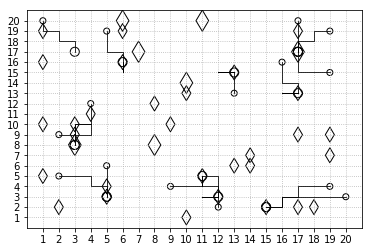

In [25]:
for i in range(caca.horizon-1):
    caca.infer(inference_type='slow')
    caca.compute_probabilities()
    caca.move_next()
    caca.update_model()
    
for agent in range(1, len(caca.aPos) + 1):
    trajectory = []
    for i in range(1, caca.horizon+1):
        trajectory.append(caca.get_pos(np.argmax(caca.mrf.unary_potentials['x' + str(i) + str(agent)])))
    if trajectory[-1] in caca.hPos:
        sth = 'hare'
    elif trajectory[-1] in caca.sPos:
        sth = 'stag'
    else:
        sth = 'nothing'
    print(trajectory, sth)
caca.display()

In [171]:
slow = StagHuntMRF()
matrix = StagHuntMRF()
slow.build_model()
matrix.build_model()

In [172]:
slow.infer(inference_type='slow')
matrix.infer(inference_type='matrix')

slow.compute_probabilities()
matrix.compute_probabilities()

slow.move_next()
slow.update_model()

matrix.move_next()
matrix.update_model()

matrix.mrf.create_matrices()
slow.mrf.create_matrices()

Belief propagation finished in 11 iterations.
Belief propagation finished in 11 iterations.


In [173]:
check = []
check.append(slow.mrf.unary_potentials.keys() == matrix.mrf.unary_potentials.keys())
for key in slow.mrf.unary_potentials:
    check.append(np.all(slow.mrf.unary_potentials[key] == matrix.mrf.unary_potentials[key]))
check.append(slow.mrf.edge_potentials.keys() == matrix.mrf.edge_potentials.keys())
for key in slow.mrf.edge_potentials:
    check.append(np.all(slow.mrf.edge_potentials[key] == matrix.mrf.edge_potentials[key]))
print(np.all(np.prod(check)))

True


In [174]:
slow.infer(inference_type='slow')
matrix.infer(inference_type='matrix')

Belief propagation finished in 10 iterations.
Belief propagation finished in 10 iterations.


In [155]:
matrix.bp.var_beliefs['x21']

array([  -1.78048568,   -1.43712269,   -1.37411534,  -99.82768477,
       -100.39419132,  -99.82768477,   -1.07654778,  -99.26143469,
        -99.28478831,  -99.82768477,  -99.76467743,  -99.26143469,
        -99.21260028,  -99.26143469,  -99.76467743,  -99.82768477,
        -99.28478831,  -99.26143469,  -99.28478831,  -99.82768477,
       -100.39419132,  -99.82768477,  -99.76467743,  -99.82768477,
       -100.39419132])

In [137]:
matrix.mrf.unary_potentials['x22']

array([-100., -100., -100., -100., -100., -100., -100., -100., -100.,
       -100., -100., -100., -100.,    0., -100., -100., -100., -100.,
       -100., -100., -100., -100., -100., -100., -100.])

In [139]:
matrix.infer(inference_type='matrix')

Belief propagation finished in 11 iterations.


In [164]:
for key in slow.mrf.unary_potentials:
    pot = slow.mrf.unary_potentials[key]
    pot = np.where(pot==-100., -np.inf, pot)
    if not np.all(pot==slow.mrf.unary_potentials[key]):
        slow.mrf.set_unary_factor(key, pot)

In [168]:
slow.mrf.unary_mat

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,  0. , -inf,  0.2,
        -inf],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -inf,  0. ,
         0. ],
       [ 0. ,  0. , -inf,  1. ,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0.2,  0. , -inf, -inf,  0.2,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -inf, -inf,  0. ,  0. ,  0. ,  0. , -inf, -inf,  0. ,
        -inf],
       [ 0. ,  0. , -

In [1]:
from staghunt import *
import numpy as np

In [2]:
caca = StagHuntMRF()

In [5]:
caca.run_game()

Belief propagation finished in 11 iterations.
Belief propagation finished in 10 iterations.
Belief propagation finished in 8 iterations.


In [16]:
caca.new_game_sample(size=(5,5), num_agents=3)

In [17]:
caca.build_model()

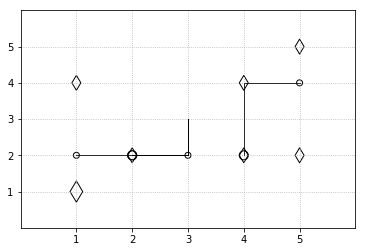

In [19]:
caca.display()

Belief propagation finished in 13 iterations.
Belief propagation finished in 12 iterations.
Belief propagation finished in 10 iterations.


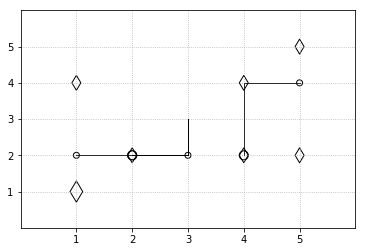

In [20]:
caca.reset_game()
caca.build_model()
caca.run_game()
caca.display()